In [60]:
import pandas as pd
from datetime import datetime
from random import seed, sample
import numpy as np

In [3]:
from sklearn.model_selection import train_test_split

In [71]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_selection import SelectFromModel, RFE

In [5]:
%load_ext autoreload

In [73]:
%autoreload 2

from fraud_utils import *

In [137]:
 print("% fraud in population" ,len(df_lbl)/len(df_dat)

SyntaxError: unexpected EOF while parsing (<ipython-input-137-288417d53008>, line 1)

In [7]:
df_dat=pd.read_csv('transactions_obf.csv')
df_lbl=pd.read_csv('labels_obf.csv')

In [8]:
df_dat.shape

(118621, 10)

In [7]:
df_lbl.shape

(875, 2)

In [8]:
len(df_lbl)/len(df_dat)

0.007376434189561713

In [55]:
def build_clean_df(df_dat,df_lbl):
    df_lbl['Fraud']=True
    df_mrg=pd.merge(df_dat,df_lbl,how='left', on='eventId')

    df_mrg.loc[df_mrg.merchantZip.isin(['....','...','0']),'merchantZip']='MISSING'
    df_mrg.loc[df_mrg.merchantZip.isna(),'merchantZip']='MISSING'

    df_mrg.loc[df_mrg.posEntryMode.isin([0]),'posEntryMode']='MISSING'

    df_mrg['reportedTime']=df_mrg['reportedTime'].fillna('')
    df_mrg['TransactionDatetime']=df_mrg['transactionTime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
    df_mrg['ReportedDatetime']=df_mrg['reportedTime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ') if x!='' else '')

    df_mrg['TransactionTimeOfDay']=df_mrg['TransactionDatetime'].apply(lambda x: x.time())

In [10]:
summary_stats(df_dat)

,Unique,# Missing,# Zeros,Available,% Available,Types,Sample
transactionTime,118105,0,0,118621,100.0,object,"[2017-07-24T07:07:41Z, 2017-06-30T08:10:39Z, 2..."
eventId,118621,0,0,118621,100.0,object,"[69705317A1, 77971747A1, 19618104A1, 28402866A..."
accountNumber,766,0,0,118621,100.0,object,"[0f8e6135, 645c318d, 4193b70e, 1c131274, 2e777..."
merchantId,33327,0,0,118621,100.0,object,"[4754c9, 377f27, 9877ee, fcc0cb, 5e0d6e, a9bfe..."
mcc,361,0,0,118621,100.0,int64,"[4814, 7922, 4829, 4215, 5942, 3008, 742, 7911..."
merchantCountry,82,0,0,118621,100.0,int64,"[492, 410, 792, 376, 52, 336, 442, 100, 710, 56]"
merchantZip,3260,23005,14474,81142,68.0,object,"[SW18, BH4, B67DJ, W69NH, CM82, N15, LE13, W24..."
posEntryMode,10,0,11,118610,100.0,int64,"[1, 80, 91, 2, 81, 0, 7, 79, 5, 90]"
transactionAmount,16431,0,1729,116892,99.0,float64,"[74.6, 29.6, 190.94, 106.82, 92.37, 15.37, 750..."
availableCash,19,0,0,118621,100.0,int64,"[13500, 3500, 18500, 15500, 9500, 16500, 10500..."


In [11]:
def analyze_feature(df,feature):
    df_anz=df[[feature,'eventId','Fraud']].groupby(feature).count()
    df_anz['Fraud%']=df_anz.apply(lambda x: round(100*x['Fraud']/x['eventId'],2),axis=1)
    
    return df_anz.sort_values('eventId', ascending=False)


In [130]:
list(analyze_feature(df_mrg,'mcc').head(3).index)

[5411, 5541, 5812]

In [13]:
flds=['merchantId','merchantCountry','transactionAmount','mcc','posEntryMode','accountNumber','TransactionTimeOfDay','merchantZip']

In [33]:

#df_mrg['TransactionDate']=df_mrg['TransactionDatetime'].apply(lambda x: x.date())
#df_mrg['ReportedDate']=df_mrg['ReportedDatetime'].apply(lambda x: x.date() if x!='' else '')

In [16]:
from IPython.display import display

for (i,fld) in enumerate(flds):
    res_df=analyze_feature(df_mrg,fld)
    outlier_df=res_df[(res_df.eventId>.01*len(df_mrg))&(res_df['Fraud%']>3*.7)]
    if len(outlier_df)>0:
        display(outlier_df)

,eventId,Fraud,Fraud%
merchantId,,,
4fd0ff,1554,49,3.15


,eventId,Fraud,Fraud%
merchantCountry,,,
840,2873,257,8.95


,eventId,Fraud,Fraud%
mcc,,,
5735,3794,120,3.16


In [53]:
%matplotlib inline 

- Is domicile feature
- One hot vector for: merchantID, mcc, merchantCountry, merchantZip, posEntryMode
- Transaction features: log of transaction amount, ratio transaction amount / median transaction amount, ratio transaction amount to median available cash
- merchantCountry previous, merchantZip

In [43]:
def pipe_initial(df_mrg, tight=True):
    '''
    Pipeline 1: Converts merged transaction and label data into
    
    
    '''
    if tight:
        params=[.99,.8,40]
    else:
        params=[.99,.95,.6]
    df_out=df_mrg.pipe(feat_cat_freq,['merchantCountry','posEntryMode'],params[0])\
                 .pipe(feat_cat_freq,['mcc'],params[1])\
                 .pipe(feat_cat_freq,['merchantId','merchantZip'],params[2])

    df_out['LOGtransactionAmount']=df_out.transactionAmount.clip(lower=1).apply(lambda x: np.log(x))
    df_out['transactionToTotalAvailable']=df_out.apply(lambda x: \
                                                       x['transactionAmount']/x['availableCash'], axis=1).clip(0,.2)
    X=df_out.drop(['transactionTime', 'eventId', 'accountNumber', 'transactionAmount',
       'availableCash', 'reportedTime', 'Fraud','TransactionDatetime', 'ReportedDatetime','TransactionTimeOfDay'], axis=1)


    Y=df_out['Fraud'].fillna(False)
    return X,Y

In [104]:
def pipe_w_prev(df_mrg, tight=True):
    '''
    Pipeline 2: Converts df_mrg (cleaned up original data) to X, Y frames ready for model ingestion
    
    Generates the following features:
    - Account features
    - Features from previous transaction (can one-hot encodes them)
    - One hot encoding for all other data features
    
    Has options tight=True/False which include different number of features from 
    two sets of predefined feature fraction parameters in order to keep computation fairly efficient
    See notes from account_features & add_prev_transaction for more
    
    
    '''
    
    #predefined feature fraction parameters
    if tight:
        params=[.99,.8,40]
    else:
        params=[.99,.95,100]
    
    df_out3=df_mrg.pipe(account_features)\
             .pipe(add_prev_transaction , ['posEntryMode','TransactionDatetime','mcc','merchantCountry'],\
                        shift_by=1)\
             .pipe(feat_cat_freq,['merchantCountry','posEntryMode','PREVmerchantCountry','PREVposEntryMode'],params[0])\
             .pipe(feat_cat_freq,['mcc','PREVmcc'],params[1])\
             .pipe(feat_cat_freq,['merchantId','merchantZip'],params[2])
                
    X=df_out3.drop(['transactionTime', 'eventId', 'accountNumber', 'transactionAmount', \
                    'availableCash', 'reportedTime', 'Fraud','TransactionDatetime', \
                    'ReportedDatetime','TransactionTimeOfDay'], axis=1)


    Y=df_out3['Fraud'].fillna(False)
    return X,Y

In [81]:
def pipe_w_prev_wide(df_mrg):
    '''
    Not tight version of Pipe 2
    '''
    return pipe_w_prev(df_mrg, tight=False)

In [82]:
data_pipes=[pipe_initial,pipe_w_prev,pipe_w_prev_wide]
data_pipe_nm=['Pipeline 1','Pipeline 2', 'Pipeline 3']

In [116]:
df_results

,ExperimentID,Label Ratio,Model,Pipe,Budget,Result
0,0,1:1,GBM,Pipeline 1,1x budget,0.485356
1,0,1:1,GBM,Pipeline 1,1.5x budget,0.665272
2,0,1:1,GBM,Pipeline 1,2x budget,0.744770
3,0,1:1,XGB,Pipeline 1,1x budget,0.531381
4,0,1:1,XGB,Pipeline 1,1.5x budget,0.656904
5,0,1:1,XGB,Pipeline 1,2x budget,0.748954
6,0,1:1,LGBM,Pipeline 1,1x budget,0.560669
7,0,1:1,LGBM,Pipeline 1,1.5x budget,0.682008
8,0,1:1,LGBM,Pipeline 1,2x budget,0.757322
9,0,1:1,XGB-Select,Pipeline 1,1x budget,0.518828


In [136]:

downsample_folds=3

budget=3*400
n_estimators=1000


df_results=big_loop(df_mrg,
             data_pipes, 
             data_pipe_nm,
             budget,
             n_estimators=n_estimators,
             downsample_folds=downsample_folds,
             label_ratios=3, 
             verbose=1)

Field: merchantCountry: Categorical Selection -  Cover: 0.991, # selected: 16, # other: 66
Field: posEntryMode: Categorical Selection -  Cover: 0.993, # selected: 4, # other: 6
Field: mcc: Categorical Selection -  Cover: 0.805, # selected: 44, # other: 317
Field: merchantId: Categorical Selection -  Cover: 0.186, # selected: 40, # other: 33287
Field: merchantZip: Categorical Selection -  Cover: 0.455, # selected: 40, # other: 3218
0 Pipe done
Index(['merchantCountry_442', 'merchantCountry_826', 'merchantCountry_840',
       'posEntryMode_1', 'posEntryMode_5', 'posEntryMode_81',
       'posEntryMode_90', 'mcc_4814', 'mcc_4816', 'mcc_5967', 'mcc_5968',
       'mcc_5999', 'mcc_6011', 'mcc_6012', 'mcc_7399', 'mcc_8999', 'mcc_other',
       'merchantId_2be1cd', 'merchantId_4fd0ff', 'merchantId_other',
       'merchantZip_MISSING', 'merchantZip_other', 'LOGtransactionAmount',
       'transactionToTotalAvailable'],
      dtype='object')
Index(['merchantCountry_442', 'merchantCountry_826', 'me

Index(['merchantCountry_442', 'merchantCountry_826', 'merchantCountry_840',
       'merchantCountry_other', 'posEntryMode_1', 'posEntryMode_5',
       'posEntryMode_81', 'mcc_4112', 'mcc_4722', 'mcc_4814', 'mcc_5411',
       'mcc_5499', 'mcc_5735', 'mcc_5967', 'mcc_5969', 'mcc_5999', 'mcc_7011',
       'mcc_other', 'merchantId_other', 'merchantZip_MISSING',
       'merchantZip_other', 'LOGtransactionAmount',
       'transactionToTotalAvailable'],
      dtype='object')
0 3 Data slices done 2019-10-08 02:44:46.840640
0 3 GBM 2019-10-08 02:44:56.583113
0 3 XGB 2019-10-08 02:45:12.542533
0 3 LGBM 2019-10-08 02:45:21.023682
0 3 XGB-Select 2019-10-08 02:45:25.384001
0 3 LGBM-Select 2019-10-08 02:45:33.011754
Index(['merchantCountry_196', 'merchantCountry_372', 'merchantCountry_826',
       'merchantCountry_840', 'merchantCountry_other', 'posEntryMode_5',
       'posEntryMode_81', 'posEntryMode_90', 'mcc_4814', 'mcc_5499',
       'mcc_5735', 'mcc_5814', 'mcc_5941', 'mcc_5967', 'mcc_6011', 'mc

Index(['transactionInDomicile', 'relativeToAcctTransactions',
       'relativeToAvailableCash', 'merchantCountry_196', 'merchantCountry_208',
       'merchantCountry_250', 'merchantCountry_442', 'merchantCountry_528',
       'merchantCountry_826', 'merchantCountry_840', 'merchantCountry_other',
       'posEntryMode_1', 'posEntryMode_5', 'posEntryMode_81',
       'posEntryMode_90', 'mcc_4814', 'mcc_5499', 'mcc_5735', 'mcc_5814',
       'mcc_5941', 'mcc_5967', 'mcc_5968', 'mcc_5999', 'mcc_6011', 'mcc_other',
       'merchantId_2be1cd', 'merchantId_422f19', 'merchantId_5025b0',
       'merchantId_7f7cdb', 'merchantId_other', 'merchantZip_LS11',
       'merchantZip_MISSING', 'merchantZip_SL1', 'merchantZip_WC2H',
       'merchantZip_other'],
      dtype='object')
Index(['transactionInDomicile', 'relativeToAcctTransactions',
       'relativeToAvailableCash', 'merchantCountry_196', 'merchantCountry_442',
       'merchantCountry_826', 'merchantCountry_840', 'merchantCountry_other',
       'po

Index(['transactionInDomicile', 'relativeToAcctTransactions',
       'relativeToAvailableCash', 'merchantCountry_196', 'merchantCountry_250',
       'merchantCountry_372', 'merchantCountry_442', 'merchantCountry_826',
       'merchantCountry_840', 'merchantCountry_other', 'posEntryMode_1',
       'posEntryMode_5', 'posEntryMode_81', 'mcc_4722', 'mcc_4814', 'mcc_5311',
       'mcc_5411', 'mcc_5651', 'mcc_5691', 'mcc_5732', 'mcc_5814', 'mcc_5941',
       'mcc_5942', 'mcc_5967', 'mcc_5968', 'mcc_5999', 'mcc_8999', 'mcc_other',
       'merchantId_2be1cd', 'merchantId_other', 'merchantZip_MISSING',
       'merchantZip_other'],
      dtype='object')
1 3 Data slices done 2019-10-08 02:59:30.368965
1 3 GBM 2019-10-08 02:59:45.455049
1 3 XGB 2019-10-08 03:00:11.971012
1 3 LGBM 2019-10-08 03:00:35.476260
1 3 XGB-Select 2019-10-08 03:00:45.736186
1 3 LGBM-Select 2019-10-08 03:01:12.829364
Field: merchantCountry: Categorical Selection -  Cover: 0.991, # selected: 16, # other: 66
Field: posEntryMod

2 2 GBM 2019-10-08 03:11:22.348973
2 2 XGB 2019-10-08 03:12:40.243347
2 2 LGBM 2019-10-08 03:13:06.939818
2 2 XGB-Select 2019-10-08 03:13:18.775276
2 2 LGBM-Select 2019-10-08 03:13:52.264625
Index(['transactionInDomicile', 'relativeToAcctTransactions',
       'relativeToAvailableCash', 'merchantCountry_124', 'merchantCountry_196',
       'merchantCountry_442', 'merchantCountry_528', 'merchantCountry_724',
       'merchantCountry_756', 'merchantCountry_826', 'merchantCountry_840',
       'merchantCountry_other', 'posEntryMode_1', 'posEntryMode_5',
       'posEntryMode_81', 'posEntryMode_90', 'mcc_4121', 'mcc_4722',
       'mcc_4812', 'mcc_4814', 'mcc_4816', 'mcc_5411', 'mcc_5499', 'mcc_5651',
       'mcc_5691', 'mcc_5732', 'mcc_5734', 'mcc_5735', 'mcc_5814', 'mcc_5964',
       'mcc_5967', 'mcc_5968', 'mcc_5977', 'mcc_5999', 'mcc_6011', 'mcc_6300',
       'mcc_7011', 'mcc_7273', 'mcc_7299', 'mcc_7372', 'mcc_7399', 'mcc_7922',
       'mcc_7995', 'mcc_8999', 'mcc_9399', 'mcc_other', 'merch

2 3 GBM 2019-10-08 03:32:09.294628
2 3 XGB 2019-10-08 03:33:41.945660
2 3 LGBM 2019-10-08 03:34:23.564627
2 3 XGB-Select 2019-10-08 03:34:35.768285
2 3 LGBM-Select 2019-10-08 03:35:01.981382
Index(['transactionInDomicile', 'relativeToAcctTransactions',
       'relativeToAvailableCash', 'merchantCountry_196', 'merchantCountry_372',
       'merchantCountry_442', 'merchantCountry_724', 'merchantCountry_826',
       'merchantCountry_840', 'merchantCountry_other', 'posEntryMode_1',
       'posEntryMode_5', 'posEntryMode_81', 'posEntryMode_90',
       'posEntryMode_other', 'mcc_4112', 'mcc_4121', 'mcc_4722', 'mcc_4812',
       'mcc_4814', 'mcc_4816', 'mcc_5310', 'mcc_5411', 'mcc_5499', 'mcc_5691',
       'mcc_5732', 'mcc_5734', 'mcc_5735', 'mcc_5812', 'mcc_5814', 'mcc_5941',
       'mcc_5942', 'mcc_5964', 'mcc_5967', 'mcc_5969', 'mcc_5977', 'mcc_5999',
       'mcc_6011', 'mcc_7011', 'mcc_7273', 'mcc_7299', 'mcc_7372', 'mcc_7399',
       'mcc_7523', 'mcc_7922', 'mcc_7995', 'mcc_8999', 'mcc_93

In [135]:


def big_loop(df_mrg,
             data_pipes, 
             data_pipe_nm,
             budget,
             n_estimators=1000,
             downsample_folds=5,
             label_ratios=3, 
             verbose=0):
    
    '''
    Purpose: Run through all selected models and different splits of the data
        - Takes a number of different pipelines that would be run through the models
        - Label ratios allow to select the proportions of negative to positive labels to consider
        - Downsample folds will iterate through different random selections of negative labels
        - Uses downsampled data to train the models but assesses results on the full test data
        - Measure is the recall (% accurately identified fraud) under budget constrain
    Inputs:
        df_mrg - merged clean frame from input data (not fully numeric, yet)
        n_estimators - nr_estimator parameters for decision tree models
        label_ratios - Nr of different negative to positive label ratios to consider. 2 means will use 1:1 and 2:1
    Outputs:
        Summary table of experiment results
    '''
    seed(1)
    ls_exp_res=[]
    for (iii,pipe) in enumerate(data_pipes):
        X,Y=pipe(df_mrg)
        print(iii,'Pipe done') if verbose>0 else ''
        X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=.25, random_state=42)

        for lbl_ratio in range(1,label_ratios+1):
            all_folds_idx=sample(list(Y_train[Y_train!=True].index),lbl_ratio*downsample_folds*sum(Y_train))

            for i in range(downsample_folds):
                down_idx=all_folds_idx[lbl_ratio*i*sum(Y_train):lbl_ratio*(i+1)*sum(Y_train)]+\
                                    list(Y_train[Y_train==True].index)
                down_idx.sort()
                Y_down=Y_train.loc[down_idx]
                X_down=X_train.loc[down_idx]
                
                sel_ = SelectFromModel(XGBClassifier(n_estimators=n_estimators))
                sel_.fit(X_down.fillna(0), Y_down)
                selected_feat_xgb = X_down.columns[(sel_.get_support())]
                print(selected_feat_xgb) if verbose>0 else ''

                sel_ = SelectFromModel(LGBMClassifier(n_estimators=n_estimators))
                sel_.fit(X_down.fillna(0), Y_down)
                selected_feat_lgbm = X_down.columns[(sel_.get_support())]
                print(selected_feat_lgbm) if verbose>0 else ''
                
                print(iii,lbl_ratio,'Data slices done', datetime.now()) if verbose>0 else ''

                gbm = GradientBoostingClassifier(n_estimators=n_estimators)
                ls_exp_res=run_classifier(X_down,
                                  Y_down,
                                  X_test,
                                  Y_test,
                                  gbm, 
                                  'GBM',
                                  ls_exp_res,
                                  lbl_ratio,
                                  data_pipe_nm[iii],i)
                print(iii,lbl_ratio,'GBM', datetime.now())   if verbose>0 else ''

                xgboost = XGBClassifier(n_estimators=n_estimators)
                ls_exp_res=run_classifier(X_down,
                                  Y_down,
                                  X_test,
                                  Y_test,
                                  xgboost, 
                                  'XGB',
                                  ls_exp_res,
                                  lbl_ratio,
                                  data_pipe_nm[iii],i)
                print(iii,lbl_ratio,'XGB', datetime.now()) if verbose>0 else ''

                lightgbm = LGBMClassifier(n_estimators=n_estimators)
                ls_exp_res=run_classifier(X_down,
                                          np.array(Y_down).reshape((len(Y_down))),
                                          X_test,
                                          Y_test,
                                          lightgbm, 
                                          'LGBM',
                                          ls_exp_res,
                                          lbl_ratio,
                                          data_pipe_nm[iii],i)
                print(iii,lbl_ratio,'LGBM', datetime.now())   if verbose>0 else ''

                xgboost =XGBClassifier(n_estimators=n_estimators)  
                ls_exp_res=run_classifier(X_down[selected_feat_xgb],
                                          Y_down,
                                          X_test[selected_feat_xgb],
                                          Y_test,
                                          xgboost, 
                                          'XGB-Select',
                                          ls_exp_res,
                                          lbl_ratio,
                                          data_pipe_nm[iii],i)
                print(iii,lbl_ratio,'XGB-Select', datetime.now())  if verbose>0 else ''


                lightgbm = LGBMClassifier(n_estimators=n_estimators)
                ls_exp_res=run_classifier(X_down[selected_feat_lgbm],
                                          np.array(Y_down).reshape((len(Y_down))),
                                          X_test[selected_feat_lgbm],
                                          Y_test,
                                          lightgbm, 
                                          'LGBM-Select',
                                          ls_exp_res,
                                          lbl_ratio,
                                          data_pipe_nm[iii],i)
                print(iii,lbl_ratio,'LGBM-Select', datetime.now())      if verbose>0 else ''


    df_exp_res=pd.DataFrame(ls_exp_res,columns=['ExperimentID','Label Ratio','Model','Pipe','Budget','Result'])
    return df_exp_res

In [134]:
def run_classifier(X_down,Y_down,X_test,Y_test,classif, classif_nm,ls_exp_res,lbl_ratio,data_pipe_nm,i):
    '''
    Helper
    '''
    classif.fit(X_down, Y_down)
    X_pred_prob=classif.predict_proba(X_test)[:,1]
    res1=recall_at_budget(Y_test,X_pred_prob,budget)
    res2=recall_at_budget(Y_test,X_pred_prob,budget*1.5)
    res3=recall_at_budget(Y_test,X_pred_prob,budget*2)
    ls_exp_res=ls_exp_res+[[i,str(lbl_ratio)+str(':1'),classif_nm,data_pipe_nm,'1x budget',res1]]
    ls_exp_res=ls_exp_res+[[i,str(lbl_ratio)+str(':1'),classif_nm,data_pipe_nm,'1.5x budget',res2]]
    ls_exp_res=ls_exp_res+[[i,str(lbl_ratio)+str(':1'),classif_nm,data_pipe_nm,'2x budget',res3]] 
    return ls_exp_res

In [85]:
df_exp_res=pd.DataFrame(ls_exp_res,columns=['ExperimentID','Label Ratio','Model','Pipe','Budget','Result'])

In [142]:
df_results2=df_results.copy()
df_results2['Result']=df_results.apply(lambda x: round(x['Result'],3),axis=1)

In [144]:
df_results2.pivot_table('Result',['Budget','Model'],['Pipe','Label Ratio',]).apply(lambda x: round(x,3)).loc[['1x budget','1.5x budget','2x budget']]

Pipe                    Pipeline 1               Pipeline 2                \
Label Ratio                    1:1    2:1    3:1        1:1    2:1    3:1   
Budget      Model                                                           
1.5x budget GBM              0.691  0.707  0.763      0.690  0.722  0.751   
            LGBM             0.696  0.710  0.739      0.678  0.729  0.723   
            LGBM-Select      0.678  0.707  0.718      0.663  0.717  0.711   
            XGB              0.686  0.720  0.730      0.686  0.738  0.732   
            XGB-Select       0.672  0.714  0.718      0.681  0.731  0.729   
1x budget   GBM              0.556  0.598  0.647      0.548  0.635  0.650   
            LGBM             0.568  0.632  0.653      0.543  0.641  0.660   
            LGBM-Select      0.552  0.612  0.616      0.530  0.636  0.638   
            XGB              0.562  0.623  0.668      0.580  0.646  0.648   
            XGB-Select       0.559  0.602  0.635      0.573  0.628  0.636   
2x budget   GBM              0.770  0.793  0.819      0.758  0.803  0.795   
            LGBM             0.761  0.770  0.795      0.732  0.775  0.764   
            LGBM-Select      0.757  0.760  0.778      0.736  0.769  0.752   
            XGB              0.760  0.778  0.796      0.750  0.780  0.766   
            XGB-Select       0.753  0.771  0.770      0.737  0.801  0.771   

Pipe                    Pipeline 3                
Label Ratio                    1:1    2:1    3:1  
Budget      Model                                 
1.5x budget GBM              0.696  0.745  0.763  
            LGBM             0.681  0.724  0.729  
            LGBM-Select      0.671  0.731  0.724  
            XGB              0.695  0.734  0.738  
            XGB-Select       0.690  0.734  0.735  
1x budget   GBM              0.577  0.619  0.637  
            LGBM             0.552  0.643  0.653  
            LGBM-Select      0.538  0.647  0.661  
            XGB              0.594  0.618  0.647  
            XGB-Select       0.590  0.621  0.648  
2x budget   GBM              0.770  0.806  0.831  
            LGBM             0.729  0.777  0.767  
            LGBM-Select      0.733  0.771  0.762  
            XGB              0.755  0.785  0.780  
            XGB-Select       0.749  0.786  0.784

In [139]:
df_results

,ExperimentID,Label Ratio,Model,Pipe,Budget,Result
0,0,1:1,GBM,Pipeline 1,1x budget,0.481172
1,0,1:1,GBM,Pipeline 1,1.5x budget,0.677824
2,0,1:1,GBM,Pipeline 1,2x budget,0.744770
3,0,1:1,XGB,Pipeline 1,1x budget,0.531381
4,0,1:1,XGB,Pipeline 1,1.5x budget,0.656904
5,0,1:1,XGB,Pipeline 1,2x budget,0.748954
6,0,1:1,LGBM,Pipeline 1,1x budget,0.560669
7,0,1:1,LGBM,Pipeline 1,1.5x budget,0.682008
8,0,1:1,LGBM,Pipeline 1,2x budget,0.757322
9,0,1:1,XGB-Select,Pipeline 1,1x budget,0.518828


In [91]:
from sklearn.model_selection import GridSearchCV

parameters_GBM = [
    #"loss":["ls"],
    #{"min_samples_split": np.linspace(0.1, 0.5, 3)},
    #{"min_samples_leaf": np.linspace(0.1, 0.5, 3)},
    #{"max_features":[None,"log2","sqrt"]},
    {"learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2]}, #
    {"max_depth":[1,5,20,30]},
     #{"criterion": ["friedman_mse",  "mae"]},
    {"subsample":[0.25,0.5, 0.75, 1.0]},#[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    {"n_estimators":[100,500,1000]}
]


parameters_LGBM = [
    {"reg_alpha":[.0001,.001,0.01,.1]}, 
    {"reg_lambda":[0.0,.5,1]},
    {"num_leaves":[5,15,31,50]},
    {"learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2]}, 
    {"max_depth":[1,5,20,30]},
    {"subsample":[0.25,0.5, 0.75, 1.0]},
    {"n_estimators":[100,500,1000]}
]

parameters_XGB = [
    {"reg_alpha":[.0001,.001,0.01,.1]}, 
    {'max_depth':[1,5,20,30]},
    {"gamma":[0.25,0.5, 0.75, 1.0]},
    {"subsample":[0.25,0.5, 0.75, 1.0]},
    {"colsample_bytree":[0.25,0.5, 0.75, 1.0]},
    {"n_estimators":[100,500,1000]},
    {"learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2]}, 
]

Precision {'reg_alpha': 0.001} Best score 0.820970802828 Time 0:00:20.690978


/Users/MD/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Recall {'reg_alpha': 0.001} Best score 0.77 Time 0:00:20.811890
Precision {'reg_lambda': 0.5} Best score 0.823564819813 Time 0:00:16.110608


/Users/MD/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Recall {'reg_lambda': 0.5} Best score 0.77 Time 0:00:16.422157
Precision {'num_leaves': 50} Best score 0.822904884564 Time 0:00:21.107072


/Users/MD/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Recall {'num_leaves': 5} Best score 0.778 Time 0:00:20.305035
Precision {'learning_rate': 0.1} Best score 0.822171600136 Time 0:00:27.608801


/Users/MD/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Recall {'learning_rate': 0.05} Best score 0.772 Time 0:00:26.472877
Precision {'max_depth': 30} Best score 0.822171600136 Time 0:00:20.428789


/Users/MD/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Recall {'max_depth': 1} Best score 0.846 Time 0:00:20.187833
Precision {'subsample': 0.25} Best score 0.822171600136 Time 0:00:20.537444


/Users/MD/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Recall {'subsample': 0.25} Best score 0.748 Time 0:00:21.554621
Precision {'n_estimators': 100} Best score 0.822171600136 Time 0:00:18.700141


/Users/MD/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Recall {'n_estimators': 100} Best score 0.748 Time 0:00:18.793528


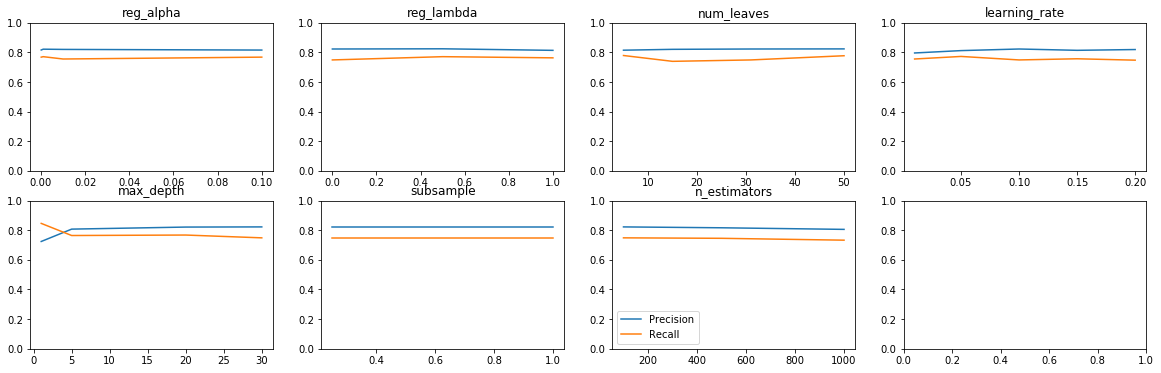

In [99]:
plot_cv_results(X_down,Y_down,parameters_LGBM,LGBMClassifier())

Precision {'reg_alpha': 0.0001} Best score 0.809273956774 Time 0:03:33.014468


/Users/MD/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Recall {'reg_alpha': 0.0001} Best score 0.778 Time 0:02:10.371351
Precision {'max_depth': 5} Best score 0.834480860797 Time 0:05:12.144269


/Users/MD/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Recall {'max_depth': 1} Best score 0.866 Time 0:04:52.665773
Precision {'gamma': 0.5} Best score 0.811386673299 Time 0:02:17.812789


/Users/MD/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Recall {'gamma': 0.75} Best score 0.788 Time 0:02:05.365217
Precision {'subsample': 0.75} Best score 0.822676762392 Time 0:01:38.037352


/Users/MD/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Recall {'subsample': 0.25} Best score 0.8 Time 0:01:35.714550
Precision {'colsample_bytree': 0.25} Best score 0.810898391534 Time 0:01:22.946055


/Users/MD/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Recall {'colsample_bytree': 0.75} Best score 0.786 Time 0:01:34.206988
Precision {'n_estimators': 500} Best score 0.836751769842 Time 0:10:18.562052


/Users/MD/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Recall {'n_estimators': 100} Best score 0.78 Time 0:09:11.075374
Precision {'learning_rate': 0.2} Best score 0.837479512886 Time 0:02:55.224911


/Users/MD/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Recall {'learning_rate': 0.01} Best score 0.921 Time 0:02:45.859854


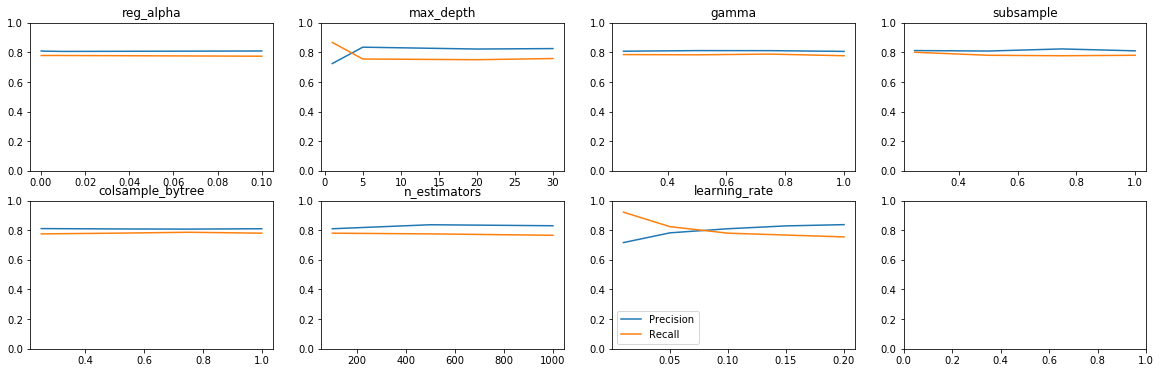

In [98]:
plot_cv_results(X_down,Y_down,parameters_XGB,XGBClassifier())

Precision {'learning_rate': 0.2} Best score 0.819710797381 Time 0:00:35.669330


/Users/MD/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Recall {'learning_rate': 0.01} Best score 0.926 Time 0:00:38.428716
Precision {'max_depth': 20} Best score 0.819951242326 Time 0:00:56.138041


/Users/MD/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Recall {'max_depth': 1} Best score 0.857 Time 0:00:47.756716
Precision {'subsample': 1.0} Best score 0.808750489701 Time 0:00:25.497489


/Users/MD/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Recall {'subsample': 1.0} Best score 0.819 Time 0:00:28.802772
Precision {'n_estimators': 1000} Best score 0.83888909375 Time 0:01:56.924910


/Users/MD/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Recall {'n_estimators': 100} Best score 0.813 Time 0:01:30.925849


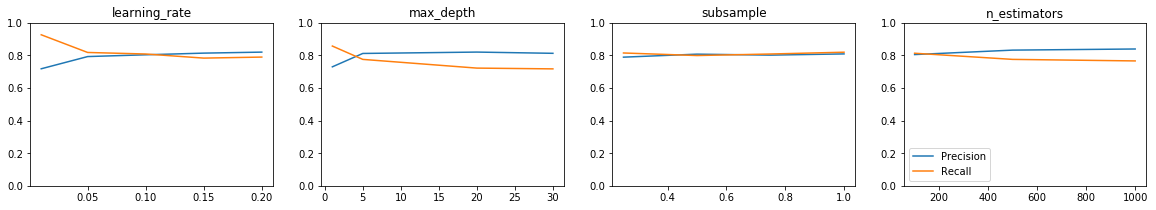

In [101]:
plot_cv_results(X_down,Y_down,parameters_GBM,GradientBoostingClassifier())

In [97]:
def plot_cv_results(X,Y,parameters,classifier):  
    key_list=[list(par.keys())[0] for par in parameters]
    fig, axs = plt.subplots(int(np.ceil(len(key_list)/4)),4, 
                            figsize=(20, int(3*np.ceil(len(key_list)/4))), 
                            facecolor='w', edgecolor='k')

    axs = axs.ravel()

    for i , key in enumerate(key_list):
        dt0=datetime.now()
        clf = GridSearchCV(classifier, parameters[i], cv=5, n_jobs=4, scoring='precision')
        clf.fit(X,Y,)
        print('Precision', clf.best_params_, 'Best score', clf.best_score_, 'Time',str(datetime.now()-dt0)) 
        clf_res=frame_cv_results(clf)
        axs[i].plot([str(tick) for tick in parameters[i][key]],clf_res['mean_test_score']\
                    ,label='Precision')
        
        dt0=datetime.now()
        clf = GridSearchCV(classifier, parameters[i], cv=5, n_jobs=4, scoring='recall')
        clf.fit(X,Y,)
        print('Recall', clf.best_params_, 'Best score', round(clf.best_score_,3), 'Time',str(datetime.now()-dt0)) 
        clf_res=frame_cv_results(clf)
        axs[i].plot([str(tick) for tick in parameters[i][key]],clf_res['mean_test_score']\
                    ,label='Recall')
        
        axs[i].set_title(key) 
        #axs[i].set_xticklabels([str(tick) for tick in parameters[i][key]])   
        if i == len(key_list)-1:
            axs[i].legend()
    plt.setp(axs, yticks=np.linspace(0,1,6))
    
    


In [93]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [95]:
def frame_cv_results(clf):
    df_cv=pd.DataFrame()

    for i in range(len(clf.cv_results_['params'])):
        df_cv=df_cv.append(clf.cv_results_['params'][i],ignore_index=True)

    metrics=['mean_test_score', 'std_test_score', ]

    for metr in metrics:
        df_cv[metr]=clf.cv_results_[metr]
    return df_cv

In [237]:
res_score(Y_test,clf.predict(X_test))

Total model positives 6686
Accuracy 0.781663069868
Precision 0.0336524080168
Recall 0.941422594142


In [312]:
boosting_type='gbdt',
class_weight=None, 
colsample_bytree=1.0,
importance_type='split', 
learning_rate=0.1, 
max_depth=-1,
min_child_samples=20, 
min_child_weight=0.001, 
min_split_gain=0.0,
n_estimators=100,
n_jobs=-1,
num_leaves=31, 
objective=None,
random_state=None, 
reg_alpha=0.0, 
reg_lambda=0.0, 


(2544, 219)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [22]:
def res_score(Y,pred_X):
    print('Total model positives', sum(pred_X))
    print('Accuracy',accuracy_score(np.array(Y).reshape((len(Y))),pred_X,))
    print('Precision',precision_score(np.array(Y).reshape((len(Y))),pred_X,))
    print('Recall',recall_score(np.array(Y).reshape((len(Y))),pred_X,))
    

In [370]:
res_score(Y_test,clf.predict(X_test)==1)

Total model positives 29656
Accuracy 0.0080590774211
Precision 0.0080590774211
Recall 1.0


In [321]:
from sklearn.feature_selection import SelectFromModel, RFE

In [360]:
sel_ = SelectFromModel(GradientBoostingClassifier())
sel_.fit(X_train.fillna(0), Y_train)
selected_feat = X_train.columns[(sel_.get_support())]
len(selected_feat)
gbc =GradientBoostingClassifier()
gbc.fit(X_down[X_train.columns[(sel_.get_support())]],Y_down)

SelectFromModel(estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                     init=None,
                                                     learning_rate=0.1,
                                                     loss='deviance',
                                                     max_depth=3,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=100,
                                            

In [361]:
selected_feat = X_train.columns[(sel_.get_support())]
len(selected_feat)

43

In [362]:
selected_feat

Index(['merchantCountry_250', 'merchantCountry_528', 'merchantCountry_724',
       'merchantCountry_826', 'merchantCountry_840', 'merchantCountry_other',
       'posEntryMode_1', 'posEntryMode_5', 'posEntryMode_81',
       'posEntryMode_90', 'PREVmerchantCountry_196.0',
       'PREVmerchantCountry_826.0', 'PREVmerchantCountry_840.0',
       'PREVposEntryMode_1', 'PREVposEntryMode_5', 'PREVposEntryMode_81',
       'PREVposEntryMode_90', 'mcc_4814', 'mcc_5732', 'mcc_5734', 'mcc_5735',
       'mcc_5964', 'mcc_5967', 'mcc_5977', 'mcc_7372', 'mcc_7995',
       'PREVmcc_4722.0', 'PREVmcc_4814.0', 'PREVmcc_5734.0', 'PREVmcc_5735.0',
       'PREVmcc_5814.0', 'PREVmcc_5942.0', 'PREVmcc_5967.0', 'PREVmcc_5969.0',
       'PREVmcc_5977.0', 'PREVmcc_6012.0', 'PREVmcc_7372.0', 'PREVmcc_7995.0',
       'PREVmcc_other', 'merchantId_2be1cd', 'merchantId_4fd0ff',
       'merchantId_other', 'merchantZip_CR0'],
      dtype='object')

In [363]:
gbc =GradientBoostingClassifier()

gbc.fit(X_down[X_train.columns[(sel_.get_support())]],Y_down)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [189]:
res_score(Y_test,gbc.predict(X_test[selected_feat]))

NameError: name 'selected_feat' is not defined

In [365]:
parameters = {
    "loss":["ls"],
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 3),
    "min_samples_leaf": np.linspace(0.1, 0.5, 3),
    "max_depth":[1,3,5,8],
    #"max_features":["log2","sqrt"],
    #"criterion": ["friedman_mse",  "mae"],
    "subsample":[0.25,0.5, 0.75, 1.0],#[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10,100,500]
    }

1200